In [1]:
import torch
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.image as mpimg
from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐


torch.cuda.is_available()

c:\Users\user\anaconda3\envs\yolov7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

def vid_info(path, codec, name, fps):
    cap = cv2.VideoCapture(path)
    print(cap)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    #재생할 파일의 높이 얻기
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    #재생할 파일의 프레임 레이트 얻기
    # fps = cap.get(cv2.CAP_PROP_FPS)
    
    #codec
    fourcc = cv2.VideoWriter_fourcc(*codec)
    
    #filename
    filename = name+'.mp4'
    
    #out 
    out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))
    
    print('cap {0}, width {1}, height {2}, fps {3}'.format(cap, width, height, fps))
    print('codec {0}', 'filename {1}'.format(fourcc, filename))
    
    return cap, width, height, fps, fourcc, filename, out


In [ ]:
 !python detect.py --weights best_v1.pt --conf 0.4 --source C:\Users\yukir\Documents\Monicas_workspace\train_diff\test_set\basic.mp4

In [ ]:
%cd C:\Users\yukir\Documents\Monicas_workspace\train_diff\workspace


### VIDEO CUT

In [ ]:
cap = cv2.VideoCapture("C:\\Users\\user\\Documents\\train_diff\\org\\testing_vid\\post.mp4")

#재생할 파일의 넓이 얻기
width = 680

#재생할 파일의 높이 얻기
height = 1080
#재생할 파일의 프레임 레이트 얻기
fps = cap.get(cv2.CAP_PROP_FPS)

print('width {0}, height {1}, fps {2}'.format(width, height, fps))

#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#저장할 파일 이름
filename = 'croped_post.mp4'

# #파일 stream 생성
out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))

frame_length = []
while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    frame = frame[0:1080, 630:1310].copy()
    # print(frame.shape)
    cv2.imshow('frame', frame)
    out.write(frame)
    frame_length.append(frame)
    if cv2.waitKey(30) == 27:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

### Find Starting Point & listing_img

In [48]:
cap = cv2.VideoCapture("C:\\Users\\user\\Documents\\train_diff\\org\\testing_vid\\post.mp4")

#재생할 파일의 넓이 얻기
width = 720

#재생할 파일의 높이 얻기
height = 1080
#재생할 파일의 프레임 레이트 얻기
fps = cap.get(cv2.CAP_PROP_FPS)

print('width {0}, height {1}, fps {2}'.format(width, height, fps))

#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#저장할 파일 이름
filename = 'detection_result_test.mp4'

# #파일 stream 생성
out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))
# out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))


if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 배경 영상 등록
ret, back = cap.read()
back = back[0:1080, 630:1310].copy()

if not ret:
    print('Background image registration failed!')
    sys.exit()
    
# 연산 속도를 높이기 위해 그레이스케일 영상으로 변환
back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)

# 가우시안 블러로 노이즈 제거 (모폴로지, 열기, 닫기 연산도 가능)
back = cv2.GaussianBlur(back, (0, 0), 1.0)

# 비디오 매 프레임 처리
test_list =[]
img_list = []
frame_num = 0 
k = 0
cap_num = 0
print('캡쳐는 ctrl+z , 안되면 두번연속!')
while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    frame = frame[0:1080, 630:1310].copy()
    img_list.append(frame)
    
    frame_num +=1 
    # 현재 프레임 영상 그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # 노이즈 제거
    gray = cv2.GaussianBlur(gray, (0, 0), 1.0)
    
    # 차영상 구하기 $ 이진화
    # absdiff는 차 영상에 절대값
    diff = cv2.absdiff(gray, back)
    # gray_mean() or 밝기정도 지정 가능
    ####!!!!!back.mean()으로 하면 smoke까지 가능?
    _, diff = cv2.threshold(diff, 70, 255, cv2.THRESH_BINARY)
    
    # 레이브링을 이용하여 바운딩 박스 표시
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(diff)

    for i in range(1, cnt):
        x, y, w, h, s = stats[i]
        if s < 100:
            continue
        test_list.append(frame_num)

    cv2.imshow('frame', frame)
    out.write(frame)

    if cv2.waitKey(30) == 27:
        break
        # cv2.imwrite('capture_{}.jpg'.format(cap_num), frame)
    

cap.release()
out.release()
cv2.destroyAllWindows()

width 720, height 1080, fps 29.97002997002997
캡쳐는 ctrl+z , 안되면 두번연속!


In [ ]:
cap = cv2.VideoCapture("C:\\Users\\user\\Documents\\train_diff\\org\\testing_vid\\post.mp4")

#재생할 파일의 넓이 얻기
width = 680

#재생할 파일의 높이 얻기
height = 1080
#재생할 파일의 프레임 레이트 얻기
fps = cap.get(cv2.CAP_PROP_FPS)

print('width {0}, height {1}, fps {2}'.format(width, height, fps))

#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#저장할 파일 이름
filename = 'croped_post.mp4'

# #파일 stream 생성
out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))

frame_length = []
while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    frame = frame[0:1080, 630:1310].copy()
    # print(frame.shape)
    cv2.imshow('frame', frame)
    out.write(frame)
    frame_length.append(frame)
    if cv2.waitKey(30) == 27:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

In [39]:
len(frame_length)

711

In [40]:
sec = 340

img_list = []
while sec < 711:
    img_list.append(frame_length[sec])
    sec +=60

In [ ]:
for i in img_list:
    show(i)

In [ ]:
# 박스사이즈
# 박스크기

In [51]:
!python train_detect.py --weights best_v2.pt --conf 0.6 --source ../detection_result_test.mp4

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../detection_result_test.mp4', update=False, view_img=False, weights=['best_v2.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/720) C:\Users\yukir\Documents\Monicas_workspace\train_diff\workspace\yolov7-custom\..\detection_result_test.mp4: Done. (9.0ms) Inference, (1.0ms) NMS
video 1/1 (2/720) C:\Users\yukir\Documents\Monicas_workspace\train_diff\workspace\yolov7-custom\..\detection_result_test.mp4: Done. (10.0ms) Inference, (1.0ms) NMS
video 1/1 (3/720) C:\Users\yukir\Documents\Monicas_workspace\train_diff\workspace\yolov7-custom\..\detection_result_test.mp4: Done. (10.0ms) Inference, (0.0

YOLOR  2022-10-8 torch 1.12.0+cu116 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11263.5625MB)

c:\Users\yukir\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


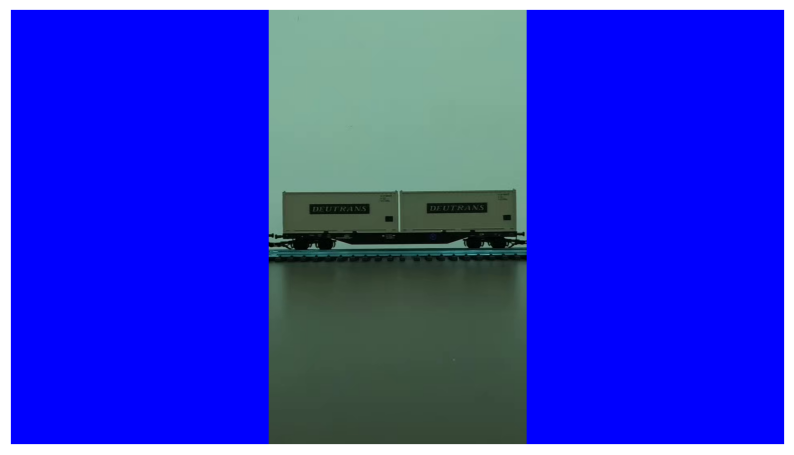

In [78]:
img = test_img.copy()
img = cv2.rectangle(img, (0, 0),(640,1080), (0,0,255), -1 )
img = cv2.rectangle(img, (1280, 0),(1920,1080), (0,0,255), -1 )
show(img)

### Similarity

In [ ]:
/pwd

'c:\\Users\\yukir\\Documents\\Monicas_workspace\\train_diff\\workspace'

In [ ]:
len(test_list)

608

In [ ]:
len(test_list_2)

608